<a href="https://colab.research.google.com/github/Giovanni-Zara/grapevine-berries-anomaly-detection-with-SAM-using-zero-shot-learning/blob/main/Copia_di_Progetto_tesi_Zara_PER_FARE_LE_PROVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

#WORKFLOW


# Analyze data - Exploratory Data Analysis (EDA)
* Regression of Classification?
* What is the target variable?
* Is the data unbalanced?
* What are the features? Correlation, ranges, variances, values, NaN, errors…
* Plot to make findings clearer
# Define the relevant metrics to be used
# Train a first baseline algorithm as a reference, e.g.:
* For regression, train a model with all the features
* For classification test basic models as the one-class-classifier (always the same class) and the
basic logistic regression with all the features
* If there is already a State of the Art solution, use it as an additional baseline
# Prepare data (where needed):
* cleaning (e.g. remove NaN, outliers, …)
* normalization
* shuffling and train, test and validation set construction
## check the statistical properties of the splits
* Design experiments and define hyperparameters
* Repeat until performance on the test set is acceptable:
* Train model and cross validate hyper parameters until acceptable performance on training set
is achieved
* Test best hyper parameter model and check if there is overfitting or underfitting
* Final Evaluation: ablation studies and failure modes

#PROJECT STRUCTURE


Dataset Preparation:

* Dataset Class: Well-define my dataset to load and preprocess the images.
* Dataset Splitting: Spliting my dataset into training, validation, and test sets. In particular I will initially split my dataset just in validation and training set, as I'm using a pretrained model for the first step.
Eventually, I will split again the segmented masks

Model Initialization:

* Load Grounded SAM:

* Initialize the Grounded SAM model for segmentation.

Segmentation:

* Segment Images: I will use Grounded SAM to segment images into different regions in two methods:
  * good samples -> from good samples i'm segmenting quite all i can extract, basically i want to reduce noise and remove background.
  * bad samples -> from bad samples i'm segmenting just the areas that the algorithm identificates as anomalies.
* Then i want to normalize this segmented masks to computationally simplify the processing of anomaly detection and classification.

Feature Extraction:

* Extract Features: I want to extract meaningful features from the segmented regions (e.g., histograms, texture features, shape features...).
In particular I want to extract the same features from the good and the bad masks.

Anomaly Detection:

* Train a Classifier: I will train a classifier (e.g., SVM, Random Forest, or a simple neural network) using the features I extracted from good grapes.
* Anomaly Detection: Use the classifier to detect anomalies in the test set.

Evaluation:

  * Metrics:

    * Evaluate the performance using precision, recall, F1-score, accuracy and other relevant metrics.

  * Visualization:

    * Results Visualization: Visualize the results by highlighting the detected anomalies

#Dataset preparation

In [2]:
import random
import numpy as np

#classe per la creazione di dataset
import os
import torch
from torch.utils.data import Dataset, Subset, DataLoader
import random
from sklearn.preprocessing import StandardScaler
import pandas as pd



class CanopiesDataset(Dataset):
    def __init__(self, root_dir, classe="every", scale="every"):
        self.root_dir = root_dir
        self.class_names = sorted(os.listdir(root_dir), reverse=True)
        self.image_paths = []

        for class_name in self.class_names:
            class_dir = os.path.join(root_dir, class_name)
            scale_dirs = os.listdir(class_dir)
            for scale_dir in scale_dirs:
                scale_path = os.path.join(class_dir, scale_dir)
                image_names = os.listdir(scale_path)
                for image_name in image_names:
                    if image_name.endswith(".jpg"):
                        if "hdr" not in image_name.lower():
                            if (classe == "every" or classe == class_name):
                                if (scale == "every" or scale == scale_dir):
                                    image_path = os.path.join(scale_path, image_name)
                                    self.image_paths.append((image_path, self.class_names.index(class_name)))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path, label = self.image_paths[idx]
        return image_path, label

    def __open_image(self, idx):
        image = Image.open(self.image_paths[idx][0]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image



def check_index(index, dataset):
  dataset_size = len(dataset)
  if(index > dataset_size):
    raise IndexError("Index out of bounds")
  return 1


def distribution(dataset, titolo):
    labels = np.array(list(zip(*dataset))[1])
    count_0 = np.sum(labels == 0)
    count_1 = len(labels) - count_0
    labels_count = np.array([count_0, count_1])
    class_names = ["good", "bad"]

    plt.figure(figsize=(8, 4))
    plt.title('Data distribution of '+ titolo)
    plt.bar(class_names, labels_count, width=.5, color = ['C0', 'C1'])
    plt.show()
    print(labels_count)

'''
from sklearn.preprocessing import StandardScaler
import pandas as pd

#normalizzazione standard
def norm_dataset(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

'''
'''
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to the same size
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])'''


'\ntransform = transforms.Compose([\n    transforms.Resize((224, 224)),  # Resize the images to the same size\n    transforms.ToTensor(),  # Convert the images to PyTorch tensors\n    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images\n])'

In [3]:
import os
import torch
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive',force_remount=True)
DATA_DIR = os.path.join("drive", "MyDrive", "Canopies-data")

Mounted at /content/drive


In [4]:
# Create an instance of the CanopiesDataset
root_dir="/content/drive/MyDrive/first_dataset"
dataset_raw = CanopiesDataset(root_dir, classe="every", scale="every")


# Check the number of images in the dataset
print(f"Total number of images: {len(dataset_raw)}")

Total number of images: 1282


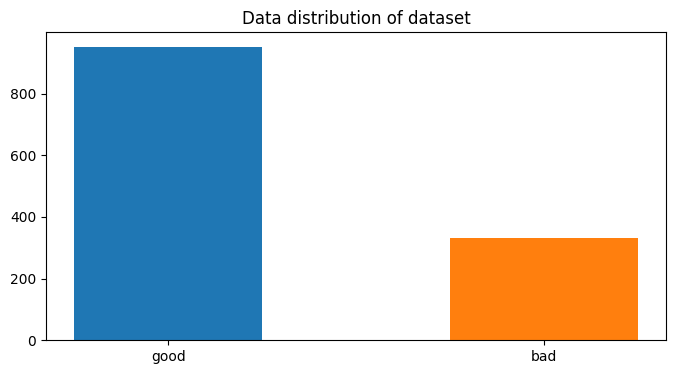

[951 331]


In [5]:
distribution(dataset_raw,"dataset")

##dataset balance considerations

As i can see from the above graph, this dataset is not perfectly balanced.
To evaluate the imbalance ratio of a dataset i analyze this formula:

$\text{Imbalance ratio} = \frac{\text{Number of samples in minority class}}{\text{Number of samples in majority class}} = \frac{350}{950} \approx 0.3684$

For problems such as mine, it's generally accepted to have an imbalance ratio about 1:3.
So for each element in the minority class(bad samples) i can have 3 elements in the majority class(good samples)

Therefore i can considerate my dataset *acceptable* with no downsampling operations to implement

##train-validation-test set splitting function

In [5]:
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """
    Splits the dataset into training, validation, and test sets.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to split.
        train_ratio (float): The proportion of the dataset to include in the training set.
        val_ratio (float): The proportion of the dataset to include in the validation set.
        test_ratio (float): The proportion of the dataset to include in the test set.

    Returns:
        tuple: A tuple containing the training, validation, and test subsets.
    """
    epsilon = 1e-10  # Small epsilon to handle floating-point precision issues
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < epsilon, "Ratios must sum to 1"

    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    random.shuffle(indices)

    train_end = int(train_ratio * dataset_size)
    val_end = train_end + int(val_ratio * dataset_size)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)

    return train_subset, val_subset, test_subset


##dataloaders function

In [5]:
def create_dataloaders(train_subset, val_subset, test_subset, batch_size=32):
    """
    Creates DataLoader objects for training, validation, and test sets.

    Args:
        train_subset (torch.utils.data.Dataset): The training subset.
        val_subset (torch.utils.data.Dataset): The validation subset.
        test_subset (torch.utils.data.Dataset): The test subset.
        batch_size (int): The number of samples per batch to load.

    Returns:
        tuple: A tuple containing DataLoader objects for the training, validation, and test sets.
    """
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [8]:
train_subset, val_subset, test_subset = split_dataset(dataset_raw, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)

# Create DataLoader objects
train_loader, val_loader, test_loader = create_dataloaders(train_subset, val_subset, test_subset, batch_size=32)

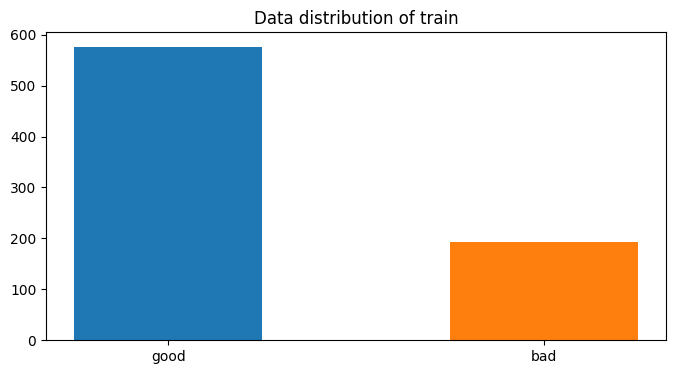

[576 193]


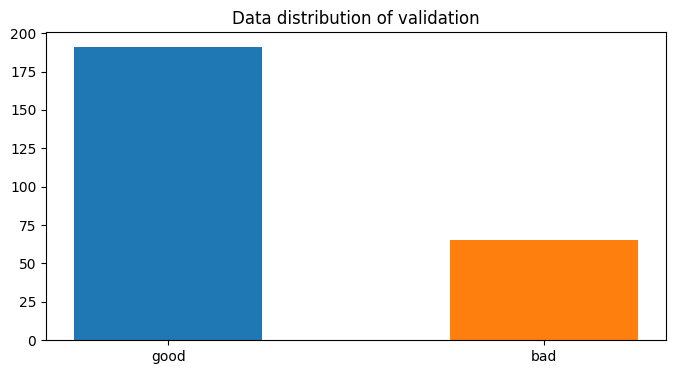

[191  65]


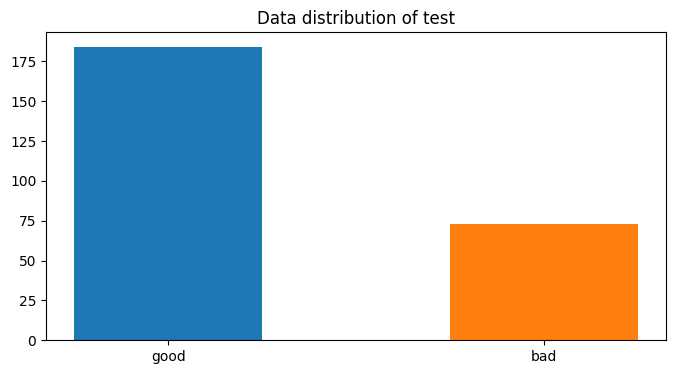

[184  73]


In [9]:
distribution(train_subset, "train")
distribution(val_subset, "validation")
distribution(test_subset, "test")

#Setting up model


In [6]:
!pip install --upgrade -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [7]:
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

import cv2
import torch
import requests
import numpy as np
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline

##Dedicated dataclass for ground dino results

In [8]:
@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(score=detection_dict['score'],
                   label=detection_dict['label'],
                   box=BoundingBox(xmin=detection_dict['box']['xmin'],
                                   ymin=detection_dict['box']['ymin'],
                                   xmax=detection_dict['box']['xmax'],
                                   ymax=detection_dict['box']['ymax']))


##Plot utils

In [9]:
def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:  #Drawing bounding boxes around detected objects. Optionally overlaying segmentation masks (if available) over the detected objects.
    # Convert PIL Image to OpenCV format
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    # Iterate over detections and add bounding boxes and masks
    for detection in detection_results:
        label = detection.label
        score = detection.score
        box = detection.box
        mask = detection.mask

        # Sample a random color for each detection
        color = np.random.randint(0, 256, size=3)

        # Draw bounding box on the images when plotting
        cv2.rectangle(image_cv2, (box.xmin, box.ymin), (box.xmax, box.ymax), color.tolist(), 2)
        cv2.putText(image_cv2, f'{label}: {score:.2f}', (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

        # If mask is available, apply it      seen on repo
        if mask is not None:
            # Convert mask to uint8
            mask_uint8 = (mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_cv2, contours, -1, color.tolist(), 2)

    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(        #actual plotting detections
    image: Union[Image.Image, np.ndarray],
    detections: List[DetectionResult],
    save_name: Optional[str] = None
) -> None:
    annotated_image = annotate(image, detections)
    plt.imshow(annotated_image)
    plt.axis('off')
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()


##Code for plots

In [10]:
def random_named_css_colors(num_colors: int) -> List[str]:
    """
    Returns a list of randomly selected named CSS colors.

    Args:
    - num_colors (int): Number of random colors to generate.

    Returns:
    - list: List of randomly selected named CSS colors.
    """
    # List of named CSS colors        #for plot utilities
    named_css_colors = [
        'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond',
        'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
        'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey',
        'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
        'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
        'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite',
        'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory',
        'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow',
        'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray',
        'lightslategrey', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine',
        'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise',
        'mediumvioletred', 'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive',
        'olivedrab', 'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
        'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'rebeccapurple', 'red', 'rosybrown', 'royalblue', 'saddlebrown',
        'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'slategrey',
        'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'white',
        'whitesmoke', 'yellow', 'yellowgreen'
    ]

    # Sample random named CSS colors
    return random.sample(named_css_colors, min(num_colors, len(named_css_colors)))

def plot_detections_plotly(     #interactive plot to change masks, it visualizes the image info hovering with mouse
    image: np.ndarray,
    detections: List[DetectionResult],
    class_colors: Optional[Dict[str, str]] = None
) -> None:
    # If class_colors is not provided, generate random colors for each class
    if class_colors is None:
        num_detections = len(detections)
        colors = random_named_css_colors(num_detections)
        class_colors = {}
        for i in range(num_detections):
            class_colors[i] = colors[i]


    fig = px.imshow(image)

    # Add bounding boxes
    shapes = []
    annotations = []
    for idx, detection in enumerate(detections):
        label = detection.label
        box = detection.box
        score = detection.score
        mask = detection.mask

        polygon = mask_to_polygon(mask)

        fig.add_trace(go.Scatter(
            x=[point[0] for point in polygon] + [polygon[0][0]],
            y=[point[1] for point in polygon] + [polygon[0][1]],
            mode='lines',
            line=dict(color=class_colors[idx], width=2),
            fill='toself',
            name=f"{label}: {score:.2f}"
        ))

        xmin, ymin, xmax, ymax = box.xyxy
        shape = [
            dict(
                type="rect",
                xref="x", yref="y",
                x0=xmin, y0=ymin,
                x1=xmax, y1=ymax,
                line=dict(color=class_colors[idx])
            )
        ]
        annotation = [
            dict(
                x=(xmin+xmax) // 2, y=(ymin+ymax) // 2,
                xref="x", yref="y",
                text=f"{label}: {score:.2f}",
            )
        ]

        shapes.append(shape)
        annotations.append(annotation)

    # Update layout
    button_shapes = [dict(label="None",method="relayout",args=["shapes", []])]
    button_shapes = button_shapes + [
        dict(label=f"Detection {idx+1}",method="relayout",args=["shapes", shape]) for idx, shape in enumerate(shapes)
    ]
    button_shapes = button_shapes + [dict(label="All", method="relayout", args=["shapes", sum(shapes, [])])]

    fig.update_layout(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        # margin=dict(l=0, r=0, t=0, b=0),
        showlegend=True,
        updatemenus=[
            dict(
                type="buttons",
                direction="up",
                buttons=button_shapes
            )
        ],
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # Show plot
    fig.show()



##other utils

In [11]:
def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the vertices of the contour
    polygon = largest_contour.reshape(-1, 2).tolist()

    return polygon

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    Convert a polygon to a segmentation mask.

    Args:
    - polygon (list): List of (x, y) coordinates representing the vertices of the polygon.
    - image_shape (tuple): Shape of the image (height, width) for the mask.

    Returns:
    - np.ndarray: Segmentation mask with the polygon filled.
    """
    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Convert polygon to an array of points
    pts = np.array(polygon, dtype=np.int32)

    # Fill the polygon with white color (255)
    cv2.fillPoly(mask, [pts], color=(255,))

    return mask

def load_image(image_str: str) -> Image.Image:
    if image_str.startswith("http"):
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        image = Image.open(image_str).convert("RGB")

    return image

def get_boxes(results: DetectionResult) -> List[List[List[float]]]:
    boxes = []
    for result in results:
        xyxy = result.box.xyxy
        boxes.append(xyxy)

    return [boxes]

def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    masks = masks.cpu().float()
    masks = masks.permute(0, 2, 3, 1)
    masks = masks.mean(axis=-1)
    masks = (masks > 0).int()
    masks = masks.numpy().astype(np.uint8)
    masks = list(masks)

    if polygon_refinement:
        for idx, mask in enumerate(masks):
            shape = mask.shape
            polygon = mask_to_polygon(mask)
            mask = polygon_to_mask(polygon, shape)
            masks[idx] = mask

    return masks

##Grounded Segment Anything (SAM)
Now it's time to define the Grounded SAM approach!

The approach is very simple:

use Grounding DINO to detect a given set of texts in the image. The output is a set of bounding boxes.
prompt Segment Anything (SAM) with the bounding boxes, for which the model will output segmentation masks.

In [12]:
def detect(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.3,
    detector_id: Optional[str] = None
) -> List[Dict[str, Any]]:
    """
    Use Grounding DINO to detect a set of labels in an image in a zero-shot fashion.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    detector_id = detector_id if detector_id is not None else "IDEA-Research/grounding-dino-tiny"
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)

    labels = [label if label.endswith(".") else label+"." for label in labels]

    results = object_detector(image,  candidate_labels=labels, threshold=threshold)
    results = [DetectionResult.from_dict(result) for result in results]

    return results

def segment(
    image: Image.Image,
    detection_results: List[Dict[str, Any]],
    polygon_refinement: bool = False,
    segmenter_id: Optional[str] = None
) -> List[DetectionResult]:
    """
    Use Segment Anything (SAM) to generate masks given an image + a set of bounding boxes.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    segmenter_id = segmenter_id if segmenter_id is not None else "facebook/sam-vit-base"

    segmentator = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)
    processor = AutoProcessor.from_pretrained(segmenter_id)

    boxes = get_boxes(detection_results)

    #if

    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to(device)

    outputs = segmentator(**inputs)
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    masks = refine_masks(masks, polygon_refinement)

    for detection_result, mask in zip(detection_results, masks):  #zip iterates tuples
        detection_result.mask = mask

    return detection_results

def grounded_segmentation(
    image: Union[Image.Image, str],
    labels: List[str],
    threshold: float = 0.3,
    polygon_refinement: bool = False,
    detector_id: Optional[str] = None,
    segmenter_id: Optional[str] = None
) -> Tuple[np.ndarray, List[DetectionResult]]:
    if isinstance(image, str):
        image = load_image(image)

    detections = detect(image, labels, threshold, detector_id)
    detections = segment(image, detections, polygon_refinement, segmenter_id)

    return np.array(image), detections


#Segmentation
Now I need to segment my masks from the good and the bad dataset with two different approaches.

I will split the good dataset in train, val and test in order to segment train, val and test masks.<br>
While the bad dataset will be splitted just in val and test, as i will not have to train the classificator also on bad features

##Bad segmentation
For the bad dataset i'm using the following logic:
I need to extract from this dataset what the algorithm detects to be a BAD patch, so a sick mask.
To do so I want to validate the model with different combination of accuracy thresholds and different combinations of text prompts.
I will then choose the combo that returns the bigger number of masks with the better accuracy.
So a mean of the masks weighted on their accuracy.

In [17]:
import random
from itertools import combinations

# Initial list of prompts with additional synonyms
prompts = [
    "rotten.", "sick.", "moldy.", "black.", "putrid.", "decomposed.",
    "diseased.", "infected.", "decayed.", "blighted.", "tainted.", "spoiled.", "wilted."
]

# Generate combinations of exactly 3 prompts
all_combinations = list(combinations(prompts, 6))

# Shuffle the combinations list to ensure randomness
random.shuffle(all_combinations)

# Ensure unique combinations to maximize diversity
unique_combinations = []
used_prompts = set()

for combo in all_combinations:
    combo_set = frozenset(combo)
    if combo_set not in used_prompts:
        unique_combinations.append(list(combo))
        used_prompts.add(combo_set)
    if len(unique_combinations) == 5:
        break

# Shuffle the prompts within each combination to add more randomness
for combo in unique_combinations:
    random.shuffle(combo)

# Print all combinations to verify
for idx, combo in enumerate(unique_combinations):
    print(f"Combination {idx + 1}: {combo}")

# Print the total number of combinations
print(f"Total number of combinations: {len(unique_combinations)}")


Combination 1: ['putrid.', 'wilted.', 'moldy.', 'sick.', 'black.', 'spoiled.']
Combination 2: ['wilted.', 'tainted.', 'rotten.', 'moldy.', 'infected.', 'blighted.']
Combination 3: ['putrid.', 'moldy.', 'wilted.', 'tainted.', 'diseased.', 'blighted.']
Combination 4: ['diseased.', 'infected.', 'sick.', 'black.', 'decomposed.', 'tainted.']
Combination 5: ['tainted.', 'putrid.', 'diseased.', 'moldy.', 'black.', 'wilted.']
Total number of combinations: 5


In [13]:
dataset_BAD = CanopiesDataset(root_dir, classe="bad", scale="every")
dataset_GOOD = CanopiesDataset(root_dir, classe="good", scale="every")

In [14]:
image_url = "/content/drive/MyDrive/first_dataset/bad/scale_2/IMG_20210924_171510186_HDR_00.jpg"
labels = ["sick .", "anomalous.", "diseased.","moldy.","black."]
threshold = 0.3

detector_id = "IDEA-Research/grounding-dino-tiny"
segmenter_id = "facebook/sam-vit-base"

###an example of what i'm doing

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


[DetectionResult(score=0.516847550868988, label='anomalous.', box=BoundingBox(xmin=271, ymin=194, xmax=491, ymax=570), mask=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)), DetectionResult(score=0.42404088377952576, label='moldy.', box=BoundingBox(xmin=60, ymin=49, xmax=307, ymax=575), mask=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)), DetectionResult(score=0.3299435079097748, label='sick .', box=BoundingBox(xmin=0, ymin=0, xmax=600, ymax=600), mask=array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0, 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
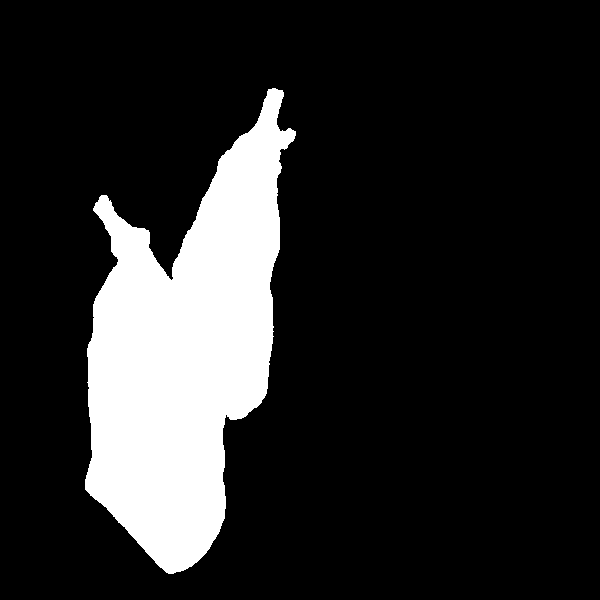

In [20]:
image_array, detections = grounded_segmentation(
    image=image_url,
    labels=labels,
    threshold=threshold,
    polygon_refinement=True,
    detector_id=detector_id,
    segmenter_id=segmenter_id
)
print(detections)
detections[1].mask

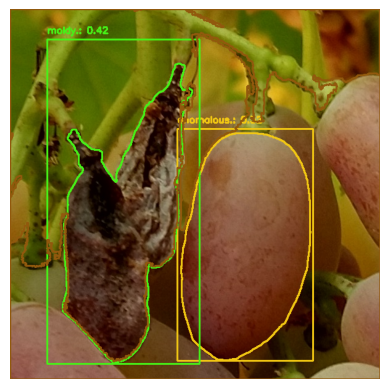

In [21]:
plot_detections(image_array, detections, "uva")

In [22]:
plot_detections_plotly(image_array, detections)

###validations of prompts
In the following cells i validate the best prompts on the first 100 bad images(for computational problems), so the prompts that can extract more patches from my bad dataset.
I iterate on a combination of shuffled useful prompts and i check the maximum number of segmented masks that these prompts produce.

If I happen to find the same number of masks for different prompts combination then I compare the accuracy score with which the masks are produced, choosing the prompts with the better one.

In [15]:
dataset_BAD_size = len(dataset_BAD)

indices = list(range(dataset_BAD_size))
random.shuffle(indices)
val_ratio = 0.3
val_end = int(val_ratio * dataset_BAD_size)
val_indices = indices[:val_end]

dataset_BAD_val_subset = Subset(dataset_BAD, val_indices)


In [15]:
dataset_BAD_train, dataset_BAD_val, dataset_BAD_test = split_dataset(dataset_BAD, 0.0, 0.3, 0.7)

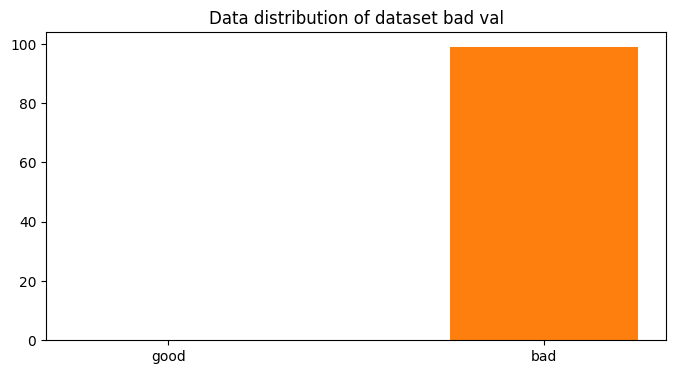

[ 0 99]


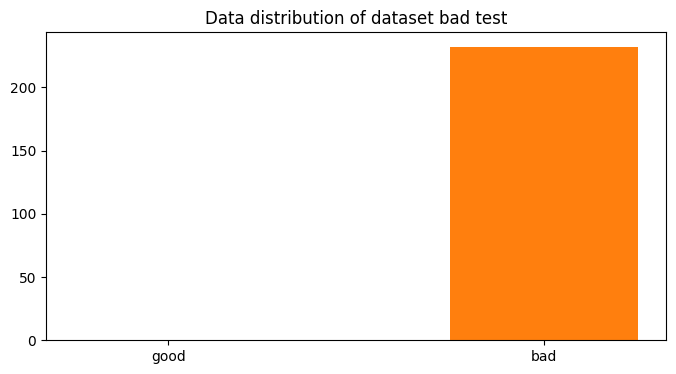

[  0 232]


In [20]:
#distribution(dataset_BAD_train, "dataset bad train")
distribution(dataset_BAD_val, "dataset bad val")
distribution(dataset_BAD_test, "dataset bad test")

In [26]:
max_masks = -1
best_prompts = None
best_detections = None
best_scores_sum = 0
cont = 0
temp = 0
for prompts in unique_combinations:
    print("combo n.", cont)
    print("best prompts so far:",best_prompts)
    num = 0
    scores_sum = 0

    for i in range(len(dataset_BAD_val)):

        try:
            image_array, detections = grounded_segmentation(
                image=dataset_BAD.__getitem__(i)[0],
                labels=prompts,
                threshold=threshold,
                polygon_refinement=True,
                detector_id=detector_id,
                segmenter_id=segmenter_id
            )

            num += len(detections)  # Sum of all masks found with this prompt
            scores_sum += sum([detection.score for detection in detections])  # Sum of all accuracy scores for subsequent comparison

            print("\timmagine n.", i, "/100")

        except IndexError:
            print(f"\tIndexError at image index {i}. Skipping this image.")
            continue

    # Change prompt
    if num > max_masks:
        max_masks = num
        best_prompts = prompts
        best_scores_sum = scores_sum
        # best_detections = detections

    elif num == max_masks:
        if scores_sum > best_scores_sum:
            best_prompts = prompts
            best_scores_sum = scores_sum
            # best_detections = detections

    cont += 1

print("so the best prompts are: ",best_prompts)

combo n. 0
best prompts so far: None
	immagine n. 0 /100
	immagine n. 1 /100
	immagine n. 2 /100
	immagine n. 3 /100
	immagine n. 4 /100
	immagine n. 5 /100
	immagine n. 6 /100
	immagine n. 7 /100
	immagine n. 8 /100
	immagine n. 9 /100
	immagine n. 10 /100
	immagine n. 11 /100
	immagine n. 12 /100
	immagine n. 13 /100
	immagine n. 14 /100
	immagine n. 15 /100
	immagine n. 16 /100
	immagine n. 17 /100
	immagine n. 18 /100
	immagine n. 19 /100
	immagine n. 20 /100
	immagine n. 21 /100
	immagine n. 22 /100
	immagine n. 23 /100
	immagine n. 24 /100
	immagine n. 25 /100
	immagine n. 26 /100
	immagine n. 27 /100
	immagine n. 28 /100
	immagine n. 29 /100
	immagine n. 30 /100
	immagine n. 31 /100
	immagine n. 32 /100
	immagine n. 33 /100
	immagine n. 34 /100
	immagine n. 35 /100
	immagine n. 36 /100
	immagine n. 37 /100
	immagine n. 38 /100
	immagine n. 39 /100
	immagine n. 40 /100
	immagine n. 41 /100
	immagine n. 42 /100
	immagine n. 43 /100
	immagine n. 44 /100
	immagine n. 45 /100
	immagi

In [16]:
best_prompts = ['blighted.', 'sick.', 'tainted.', 'putrid.', 'black.', 'rotten.']
print(best_prompts)

['blighted.', 'sick.', 'tainted.', 'putrid.', 'black.', 'rotten.']


###segment with best hyperparameters
Now that I have chosen the better prompts among my combination, i can segment all the bad dataset to obtain the mask from which i have to extract features

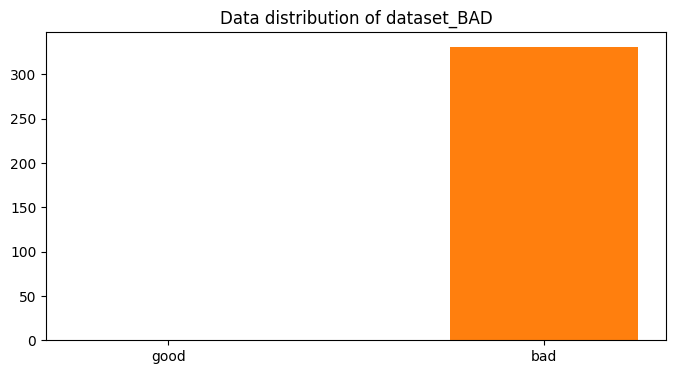

[  0 331]


In [17]:
distribution(dataset_BAD, "dataset_BAD")

In [17]:
cont = 0
bad_masks=[]
bad_boxes=[]
detections_list=[]
for i in range(len(dataset_BAD)):
    try:
        image_array, detections = grounded_segmentation(
            image=dataset_BAD.__getitem__(i)[0],
            labels=best_prompts,
            threshold=threshold,
            polygon_refinement=True,
            detector_id=detector_id,
            segmenter_id=segmenter_id
        )
        detections_list.append(detections)
        for item in detections:
          bad_masks.append(item.mask)   ##appending all the masks in a list
          bad_boxes.append(item.box)

        #num += len(detections)  # Sum of all masks found with this prompt
        #scores_sum += sum([detection.score for detection in detections])  # Sum of all accuracy scores for subsequent comparison

        print("\timmagine n.", i, "/",len(dataset_BAD))


    except IndexError:        ##if it doesn't find any masks for an image
        print(f"\tIndexError at image index {i}. Skipping this image.")
        continue


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


	immagine n. 0 / 331
	immagine n. 1 / 331
	immagine n. 2 / 331
	immagine n. 3 / 331
	immagine n. 4 / 331
	immagine n. 5 / 331
	immagine n. 6 / 331
	immagine n. 7 / 331
	immagine n. 8 / 331
	immagine n. 9 / 331
	immagine n. 10 / 331
	immagine n. 11 / 331
	immagine n. 12 / 331
	immagine n. 13 / 331
	immagine n. 14 / 331
	immagine n. 15 / 331
	immagine n. 16 / 331
	immagine n. 17 / 331
	immagine n. 18 / 331
	immagine n. 19 / 331
	immagine n. 20 / 331
	immagine n. 21 / 331
	immagine n. 22 / 331
	immagine n. 23 / 331
	immagine n. 24 / 331
	immagine n. 25 / 331
	immagine n. 26 / 331
	immagine n. 27 / 331
	immagine n. 28 / 331
	immagine n. 29 / 331
	immagine n. 30 / 331
	immagine n. 31 / 331
	immagine n. 32 / 331
	immagine n. 33 / 331
	immagine n. 34 / 331
	immagine n. 35 / 331
	immagine n. 36 / 331
	immagine n. 37 / 331
	immagine n. 38 / 331
	immagine n. 39 / 331
	immagine n. 40 / 331
	immagine n. 41 / 331
	immagine n. 42 / 331
	immagine n. 43 / 331
	immagine n. 44 / 331
	immagine n. 45 / 33

In [19]:
print(detections_list)


[[DetectionResult(score=0.4787747263908386, label='sick.', box=BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), mask=array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)), DetectionResult(score=0.3758176863193512, label='black.', box=BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), mask=array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)), DetectionResult(score=0.31931644678115845, label='rotten.', box=BoundingBox(xmin=229, ymin=66, xmax=406, ymax=204), mask=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]

In [23]:
print(bad_masks)


[array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8), array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  

In [32]:
print(bad_boxes)

[BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=229, ymin=66, xmax=406, ymax=204), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=107, ymin=106, xmax=347, ymax=412), BoundingBox(xmin=107, ymin=105, xmax=347, ymax=412), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=106, ymin=106, xmax=347, ymax=413), BoundingBox(xmin=0, ymin=0, xmax=450, ymax=449), BoundingBox(xmin=106, ymin=103, xmax=348, ymax=412), BoundingBox(xmin=190, ymin=0, xmax=337, ymax=197), BoundingBox(xmin=74, ymin=0, xmax=242, ymax=121), BoundingBox(xmin=14, ymin=0, xmax=422, ymax=449), BoundingBox(xmin=14, ymin=0, xmax=421, ymax=449), BoundingBox(xmin=63, ymin=112, xmax=242, ymax=416), BoundingBox(xmin=20, ymin=0, xmax=352, ym

###normalizing masks

In [39]:
def normalize_resize_array_mean_std(array):
    """
    Normalize a numpy array using its mean and standard deviation.

    Parameters:
    array (np.ndarray): The input array to normalize.

    Returns:
    np.ndarray: The normalized array.
    """
    desired_size = (244, 244)

    # Resize each array to desired size
    resized_arrays = [cv2.resize(arr, desired_size) for arr in array]
    mean = np.mean(array)
    std = np.std(array)

    # Avoid division by zero
    if std == 0:
        return array - mean

    normalized_array = (array - mean) / std
    return normalized_array

In [26]:
for mask in bad_masks:
  print(mask)
  print("-----------------------------------------------------------------------------")

Output streaming troncato alle ultime 5000 righe.
[[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
-----------------------------------------------------------------------------
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]
-----------------------------------------------------------------------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
-----------------------------------------------------------------------------
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]
--------------------

In [18]:
desired_size = (244, 244)
resized_arrays = [cv2.resize(arr, desired_size) for arr in bad_masks]
mean_value = np.mean(np.stack(resized_arrays))
std_value = np.std(np.stack(resized_arrays))

# Step 2: Normalize each array
n_bad_masks = [(arr - mean_value) / std_value for arr in resized_arrays]

In [40]:
#n_bad_masks = []
#for mask in bad_masks:
#  n_mask = normalize_resize_array_mean_std(mask)
#  n_bad_masks.append(n_mask)

KeyboardInterrupt: 

##Good segmentation
For the good dataset I aim to extract whatever i can, removing the noise and the background.
Then I'll normalize these masks as well and

###an example of what i'm doing

In [28]:
image_url = "/content/drive/MyDrive/first_dataset/good/scale_2/IMG_20210924_160155838_0_00.jpg"
labels = ["grape berry.", "green grape.", "red grape.","grapes.","grape.", "good grape"]
threshold = 0.4

detector_id = "IDEA-Research/grounding-dino-tiny"
segmenter_id = "facebook/sam-vit-base"

[DetectionResult(score=0.8658604025840759, label='grape berry.', box=BoundingBox(xmin=0, ymin=0, xmax=599, ymax=600), mask=array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)), DetectionResult(score=0.8535763025283813, label='grapes.', box=BoundingBox(xmin=0, ymin=0, xmax=599, ymax=599), mask=array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)), DetectionResult(score=0.7698561549186707, label='green grape.', box=BoundingBox(xmin=0, ymin=0, xmax=599, ymax=600), mask=array([[255, 255, 255, ..., 255, 255, 255],
       [25

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)
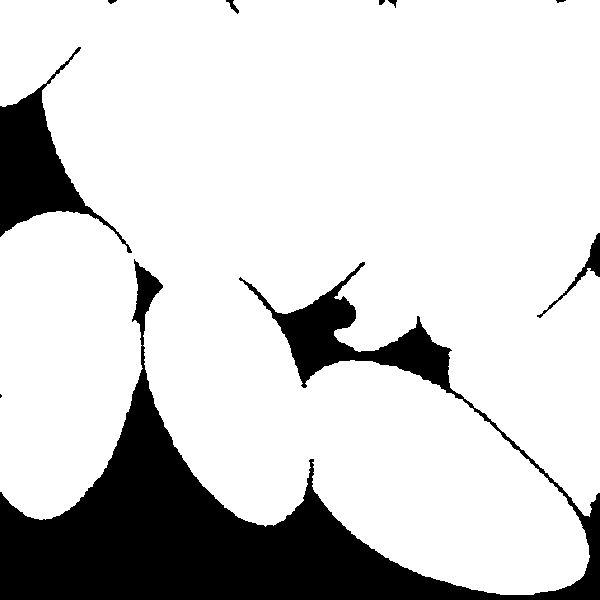

In [27]:
image_array, detections = grounded_segmentation(
    image=image_url,
    labels=labels,
    threshold=threshold,
    polygon_refinement=True,
    detector_id=detector_id,
    segmenter_id=segmenter_id
)
print(detections)
detections[1].mask

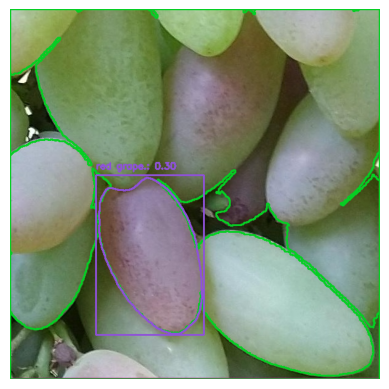

In [28]:
plot_detections(image_array, detections, "uva")

In [29]:
plot_detections_plotly(image_array, detections)

###Actual segmentation
Since i've decided to try to segment basically all the model can on the good dataset, i have no need to validate.<br>
Based on some tests i've done and on the model's paper, the performances of the model "easier" prompts are generally way better and similar in accuracy
Hence, i'm iterating on a combination of useful prompts to segment my good masks

In [29]:
max_masks = -1
good_masks=[]
good_boxes=[]
detections_list_good=[]
labels = ["grape berry.", "green grape.", "red grape.","grapes.","grape.", "good grape"]
for i in range(len(dataset_GOOD)):
    try:
        image_array, detections = grounded_segmentation(
            image=dataset_GOOD.__getitem__(i)[0],
            labels=labels,
            threshold=threshold,
            polygon_refinement=True,
            detector_id=detector_id,
            segmenter_id=segmenter_id
        )
        detections_list_good.append(detections)
        for item in detections:
          good_masks.append(item.mask)   ##appending all the masks in a list
          good_boxes.append(item.box)


        #num += len(detections)  # Sum of all masks found with this prompt
        #scores_sum += sum([detection.score for detection in detections])  # Sum of all accuracy scores for subsequent comparison

        print("\timmagine n.", i, "/", len(dataset_GOOD))


    except IndexError:        ##if it doesn't find any masks for an image
        print(f"\tIndexError at image index {i}. Skipping this image.")
        continue


	immagine n. 0 / 951
	immagine n. 1 / 951
	IndexError at image index 2. Skipping this image.
	IndexError at image index 3. Skipping this image.
	immagine n. 4 / 951
	immagine n. 5 / 951
	immagine n. 6 / 951
	immagine n. 7 / 951
	immagine n. 8 / 951
	immagine n. 9 / 951
	immagine n. 10 / 951
	immagine n. 11 / 951
	IndexError at image index 12. Skipping this image.
	immagine n. 13 / 951
	immagine n. 14 / 951
	IndexError at image index 15. Skipping this image.
	immagine n. 16 / 951
	immagine n. 17 / 951
	immagine n. 18 / 951
	IndexError at image index 19. Skipping this image.
	immagine n. 20 / 951
	immagine n. 21 / 951
	immagine n. 22 / 951
	immagine n. 23 / 951
	immagine n. 24 / 951
	immagine n. 25 / 951
	immagine n. 26 / 951
	immagine n. 27 / 951
	immagine n. 28 / 951
	immagine n. 29 / 951
	immagine n. 30 / 951
	immagine n. 31 / 951
	immagine n. 32 / 951
	immagine n. 33 / 951
	immagine n. 34 / 951
	immagine n. 35 / 951
	immagine n. 36 / 951
	immagine n. 37 / 951
	immagine n. 38 / 951
	i

###normalizing good masks

In [30]:
desired_size = (244, 244)
resized_arrays = [cv2.resize(arr, desired_size) for arr in good_masks]
mean_value = np.mean(np.stack(resized_arrays))
std_value = np.std(np.stack(resized_arrays))

# Step 2: Normalize each array
n_good_masks = [(arr - mean_value) / std_value for arr in resized_arrays]

In [43]:
print(good_boxes)

[BoundingBox(xmin=0, ymin=0, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=300), BoundingBox(xmin=66, ymin=97, xmax=300, ymax=300), BoundingBox(xmin=66, ymin=96, xmax=300, ymax=300), BoundingBox(xmin=66, ymin=97, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=128, ymax=254), BoundingBox(xmin=66, ymin=97, xmax=300, ymax=300), BoundingBox(xmin=66, ymin=97, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=126, ymax=254), BoundingBox(xmin=86, ymin=0, xmax=299, ymax=105), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=299), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=300), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=299), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=299), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=299), BoundingBox(xmin=0, ymin=0, xmax=300, ymax=299), Bounding

#Feature extractions
Now i have to extract features from the good and the bad masks that I've segmented.

I could manually extract features like histograms of pixel intensities, shape features, edge detections, statistical features....
But it's more efficient to use a Convolutional Neural Network trained for feature extraction.<br>
CNNs automatically learn relevant features from the data, eliminating the need for manual feature extraction and selection.
They have a hierarchical learning approach to features, starting from simple edges till more comples structures.<br>
A CNN can generalize better to unseen data, provided they are trained on large and diverse datasets. They can capture intricate patterns that traditional features might miss.

I am going to use a pretrained CNN model, ResNet, following these steps:
* load the CNN and load the model;
* remove the last layers (classification layers) to get feature vector from the convolutional layers;
* transform the image and normalize it with the mean and std used in the model (resnet ones);
* extracting features and putting them into np arrays

For this task I'm gonna use VGG16 (Visual Geometry Group 16), a convolutional neural network architecture that was proposed by the Visual Geometry Group at the University of Oxford. It is part of the VGG family of models, which were developed for image classification and object detection task.


###setting up vgg16

In [ ]:
!pip install tensorflow

In [ ]:
# Load VGG16 model with pre-trained weights and exclude the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False)

In [ ]:
# Define the model to output features from the last convolutional block
#model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

###good features extraction

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import torch


# Step 1: Create 3-channel images
list_of_rgb_arrays = [np.stack((img, img, img), axis=-1) for img in n_good_masks]

# Step 2: Convert to PyTorch tensors
list_of_tensors = [torch.tensor(arr) for arr in list_of_rgb_arrays]

# Step 3: Organize into a single tensor
final_tensor = torch.stack(list_of_tensors)

# Print shapes for verification
#print(f"Shape of final tensor: {final_tensor.shape}")
final_tensor_np = final_tensor.numpy()##i convert to numpy cause tensor does not support a negative strip operation that the model does!!

images = preprocess_input(final_tensor_np)  # Preprocess input for VGG16

#model = VGG16(weights='imagenet', include_top=False)

# Extract features
good_masks_features = model.predict(images)

# The shape of features will be (number of images, 7, 7, 512) for VGG16 with 'block5_pool' layer
print(good_masks_features.shape)
#EUREKA, IT WORKS!

151/151 [==============================] - 5s 31ms/step
(4816, 7, 7, 512)


In [32]:
print(good_masks_features)

[[[[ 0.          0.          0.         ...  0.          1.2199398
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]

  [[ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]

  [[ 0.          0.          0.         ...  0.    

In [34]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Step 2: Save the features
import numpy as np
np.save('/content/drive/MyDrive/good_masks_features_new.npy', good_masks_features)

# Later, to load the features again

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Load the features
good_masks_features = np.load('/content/drive/MyDrive/good_masks_features_new.npy')


Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###bad features extraction

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import torch


# Step 1: Create 3-channel images because my masks are greyscaled so I need to "fake" the rgb stacking 3 identical layer
list_of_rgb_arrays = [np.stack((img, img, img), axis=-1) for img in n_bad_masks]

# Step 2: Convert to PyTorch tensors
list_of_tensors = [torch.tensor(arr) for arr in list_of_rgb_arrays]

# Step 3: Organize into a single big tensor
final_tensor = torch.stack(list_of_tensors)

# Print shapes for verification
#print(f"Shape of final tensor: {final_tensor.shape}")
final_tensor_np = final_tensor.numpy()##i convert to numpy cause tensor does not support a negative strip operation that the model does!!

images = preprocess_input(final_tensor_np)  # Preprocess input for VGG16

model = VGG16(weights='imagenet', include_top=False)

# Extract features
bad_masks_features = model.predict(images)

# The shape of features will be (number of images, 7, 7, 512) for VGG16 with 'block5_pool' layer
print(bad_masks_features.shape)
#EUREKA, IT WORKS!

92/92 [==============================] - 6s 38ms/step
(2938, 7, 7, 512)


In [61]:
print(bad_masks_features)

[[[[ 0.          0.          0.         ...  0.          0.93761516
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          3.4900553
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]

  [[ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   ...
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]
   [ 0.          0.          0.         ...  0.          0.
     0.        ]]

  [[ 0.          0.          0.         ...

In [21]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Step 2: Save the features
import numpy as np
np.save('/content/drive/MyDrive/bad_masks_features.npy', bad_masks_features)

# Later, to load the features again

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Load the features
bad_masks_features = np.load('/content/drive/MyDrive/bad_masks_features.npy')


Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Anomaly detection

#Evaluation and confront

#TEST

In [45]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
resnet152 = models.resnet152(pretrained=True)
modules=list(resnet152.children())[:-1]
resnet152=nn.Sequential(*modules)
for p in resnet152.parameters():
    p.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
import numpy as np
import torch

#list of grayscale images (shape [244, 244])
list_of_arrays = n_bad_masks

# Step 1: Create 3-channel images
list_of_rgb_arrays = [np.stack((img, img, img), axis=-1) for img in list_of_arrays]

# Step 2: Convert to PyTorch tensors
list_of_tensors = [torch.tensor(arr) for arr in list_of_rgb_arrays]

# Step 3: Organize into a single tensor
final_tensor = torch.stack(list_of_tensors)

# Print shapes for verification


# Print shapes for verification
print(f"Shape of final tensor: {final_tensor.shape}")

final_tensor = final_tensor.permute(0, 3, 1, 2)
print(f"Shape of final tensor after permutation: {final_tensor.shape}")

#final_tensor = final_tensor.double()


Shape of final tensor: torch.Size([2938, 244, 244, 3])
Shape of final tensor after permutation: torch.Size([2938, 3, 244, 244])


In [52]:
batch_size = 10  # Adjust batch size as needed
num_images = final_tensor.shape[0]
num_batches = (num_images + batch_size - 1) // batch_size
print(num_batches)

294


In [53]:
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_images)
    batch_tensor = final_tensor[start_idx:end_idx]

    # Convert to DoubleTensor if necessary
    batch_tensor = batch_tensor.double()

    # Create a Variable and pass through ResNet152
    img_var = torch.autograd.Variable(batch_tensor)
    features_var = resnet152(img_var)

    # Get the tensor out of the variable and append to list
    features_list.append(features_var.data)

# Concatenate results from all batches
features = torch.cat(features_list, dim=0)

RuntimeError: expected scalar type Double but found Float

In [56]:
import torch

# Assuming final_tensor is your tensor with shape [num_images, 3, 244, 244]
batch_size = 10  # Adjust batch size as needed
num_images = final_tensor.shape[0]
num_batches = (num_images + batch_size - 1) // batch_size  # Calculate number of batches

features_list = []

# Process images in batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_images)
    batch_tensor = final_tensor[start_idx:end_idx]

    # Convert to DoubleTensor explicitly **BEFORE** creating the Variable
    batch_tensor = batch_tensor.double()

    # Create a Variable and pass through ResNet152
    img_var = torch.autograd.Variable(batch_tensor)
    features_var = resnet152(img_var)

    # Get the tensor out of the variable and append to list
    features_list.append(features_var.data)

# Concatenate results from all batches
features = torch.cat(features_list, dim=0)

# Now `features` contains the output features from ResNet152 for all images

RuntimeError: expected scalar type Double but found Float

In [36]:
print(features)

tensor([[[[0.6463]],

         [[0.3609]],

         [[0.6693]],

         ...,

         [[0.3550]],

         [[0.5867]],

         [[0.2719]]],


        [[[0.9885]],

         [[0.6146]],

         [[1.1287]],

         ...,

         [[0.4313]],

         [[0.0857]],

         [[0.5082]]]])


In [32]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np

# Example matrix data (replace with your actual data)
matrix_list = [np.random.rand(224, 224) for _ in range(10)]

# Preprocess data
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL Image
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize((224, 224)),  # Resize to match model's expected input size
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet standards
])

# Load pre-trained model
# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()  # Set model to evaluation mode

# Feature extraction function
def extract_features(model, input_matrix):
    # Apply transformation to input matrix
    input_tensor = transform(input_matrix).unsqueeze(0)  # Add batch dimension
    input_variable = Variable(input_tensor)  # Wrap input tensor in Variable

    # Forward pass through the model
    output = model.features(input_variable)

    # Flatten the output tensor
    feature_vector = output.view(output.size(0), -1)

    return feature_vector.data.numpy()  # Convert to NumPy array

# Extract features for each matrix
extracted_features = []
for matrix in matrix_list:
    features = extract_features(model, matrix)
    extracted_features.append(features)

# Now extracted_features is a list of feature vectors, each corresponding to one matrix in matrix_list
print("Extracted features shape:", extracted_features[0].shape)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


AttributeError: 'ResNet' object has no attribute 'features'

In [29]:
import torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset

# Define your dataset class (assuming you have a custom dataset class already)

class MasksDataset(Dataset):
    def __init__(self, masks_list, transform=None):
        self.masks_list = masks_list
        self.transform = transform

    def __len__(self):
        return len(self.masks_list)

    def __getitem__(self, idx):
        mask = self.masks_list[idx]
        if self.transform:
            mask = self.transform(mask)
        return mask, idx  # Return mask and its index

# Example list of masks (replace with your own data)
masks_list = [np.random.randint(0, 2, size=(224, 224), dtype=np.uint8) for _ in range(10)]

# Define transformation (resize and normalize as needed)
transform = transforms.Compose([
    transforms.ToPILImage(),                    # Convert numpy array to PIL Image
    transforms.Resize((224, 224)),              # Resize to match model input size
    transforms.ToTensor(),                      # Convert PIL Image to tensor
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize as per ImageNet statistics
])

# Create dataset instance
dataset = MasksDataset(masks_list, transform=transform)

# Load pre-trained VGG16 model
vgg16 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
vgg16.eval()  # Set the model to evaluation mode

features_list = []

# Iterate through dataset to extract features from each mask
for mask, idx in dataset:
    mask_tensor = mask.unsqueeze(0).float()  # Add batch dimension and convert to float tensor

    # Pass the mask through VGG16 to extract features
    with torch.no_grad():
        features = vgg16.features(mask_tensor)
        features = features.view(features.size(0), -1)  # Flatten the features

    # Convert features to numpy array and store in the list
    features_np = features.numpy()
    features_list.append(features_np)

print(f"Extracted features from {len(features_list)} masks")


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 1, 224, 224] to have 3 channels, but got 1 channels instead